In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
#nltk.download('stopwords')
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import textblob as tb
import textblob as tb
from tqdm import tqdm
from collections import Counter

In [2]:
import sqlite3
db_path = 'all-the-news.db'
conn = sqlite3.connect(db_path)

## Read data from dataset and drop the empty records

In [3]:
data = pd.read_sql_query("SELECT * FROM longform",conn).dropna()
print(data.head())

          id                                              title  \
71862  82596  Donald Trump blasts Bill Clinton as 'one of th...   
71866  82600  Drop in oil prices rocks producer states, trig...   
71870  82605  Open carry comes to Texas: Why the Lone Star s...   
71884  82621  GOP field rips Obama's move toward executive a...   
71892  82630            President Obama wants to disarm America   

                   author        date  \
71862  Christopher Snyder  2015-12-30   
71866      Brooke Singman  2016-01-01   
71870         John R Lott  2015-12-30   
71884        Joseph Weber  2016-01-03   
71892        Todd Starnes  2016-01-04   

                                                 content  year month  \
71862  [Sign in to comment!, Donald Trump launched ne...  2015    12   
71866  [Sign in to comment!, The plunge in oil prices...  2016     1   
71870  [Sign in to comment!, With about 900,000 conce...  2015    12   
71884  [Sign in to comment!, Republican presidential ...  2016

In [4]:
print(data.size)

460248


In [5]:
#data = data.dropna()
news = data['content']
print(news.size)
print(data.size)

38354
460248


In [6]:
englishStopWords = set(nltk.corpus.stopwords.words('english'))
stopWordsDictionary = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

## Clean the data and transform into a bag of words matrix (i.e., each document represented as a row, with each columns containing the count of words in the corpus). 

In [8]:
no_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2,max_features=no_features, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(news)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#print(tfidf_vectorizer)

In [9]:
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(news)
tf_feature_names = tf_vectorizer.get_feature_names()
#print(tf)

In [10]:
no_topic = 5

In [11]:
lda_withoutfit = LatentDirichletAllocation(n_components=no_topic, max_iter = 5, learning_method = 'online', learning_offset=50., random_state=0)
lda = lda_withoutfit.fit(tf)


## Use LDA transform all the documents into topic distribution matrix

In [12]:
lda_doc_topic = lda_withoutfit.transform(tf)

In [13]:
print(lda_doc_topic.size)

191770


# Topic Modelling And Key-Phrases extraction

In [14]:
no_top_words = 10
display_topics(lda , tf_feature_names , no_top_words)

Topic 0:
trump president said clinton campaign obama donald house republican election
Topic 1:
said says people health company new year percent million news
Topic 2:
like people just says said time don years know year
Topic 3:
said court law state federal school case students rights government
Topic 4:
said police state officials government security russia military told russian



## Determine what topic a given document is about.

### To find that, we find the topic number that has the highest percentage probability in document.


In [15]:

def format_topics_sentences(ldamodel=None, content=news):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel):
        topic_num = np.argmax(row_list)            
        #print(row_list)
        prop_topic = row_list[topic_num]
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']
    polarity = []
    sub = []
    for text in content:
        t = tb.TextBlob(text)
        polarity.append(t.sentiment.polarity)
        sub.append(t.sentiment.subjectivity)
    # Add original text to the end of the output
    contents = pd.Series(data.content.values.tolist())
    year = pd.Series(data.year.values.tolist())
    month = pd.Series(data.month.values.tolist())
    polarity = pd.Series(polarity)
    sub = pd.Series(sub)
    
    sent_topics_df = pd.concat([sent_topics_df, contents, polarity, sub, year, month], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_doc_topic, content=news)


In [16]:
df_dominant_topic = df_topic_sents_keywords.reset_index()

# Topic and its sentiment for each Article

In [17]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc', 'Text', "Polarity", "Sub", 'Year', 'Month']
print("Topic and its sentiment for each article")
df_dominant_topic

Topic and its sentiment for each article


,Document_No,Dominant_Topic,Topic_Perc,Text,Polarity,Sub,Year,Month
0,0,0.0,0.8799,"[Sign in to comment!, Donald Trump launched ne...",0.079453,0.428480,2015,12
1,1,1.0,0.6719,"[Sign in to comment!, The plunge in oil prices...",0.083317,0.430492,2016,1
2,2,1.0,0.3645,"[Sign in to comment!, With about 900,000 conce...",0.064611,0.434401,2015,12
3,3,0.0,0.5992,"[Sign in to comment!, Republican presidential ...",0.125330,0.441313,2016,1
4,4,0.0,0.5163,"[Sign in to comment!, President Obama is plott...",0.121199,0.371928,2016,1
5,5,3.0,0.4564,"[Sign in to comment!, As armed protesters occu...",0.095955,0.425501,2016,1
6,6,0.0,0.3936,"[Sign in to comment!, Saudi Arabia's execution...",-0.049531,0.443125,2016,1
7,7,2.0,0.8486,[2015 was a tough year for country music. From...,0.044592,0.438463,2015,12
8,8,0.0,0.6368,"[Sign in to comment!, **Want FOX News First in...",0.125258,0.426224,2016,1
9,9,2.0,0.5692,"[Sign in to comment!, The president shed tears...",0.025806,0.516737,2016,1


In [22]:
dateGrouped = df_dominant_topic.groupby([df_dominant_topic['Year'], df_dominant_topic['Month']])

date_list = []
topic0_list = []
topic1_list = []
topic2_list = []
topic3_list = []
topic4_list = []

mean_pol = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}
sub_pol = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}


for name, group in df_dominant_topic.groupby([df_dominant_topic['Year'], df_dominant_topic['Month']]):
        #print (name)
        #print (group)
        c = Counter(group['Dominant_Topic'])
        date_list.append(str(name[0])+"-"+str(name[1]))
        topic0_list.append(c[0])
        topic1_list.append(c[1])        
        topic2_list.append(c[2])
        topic3_list.append(c[3])  
        topic4_list.append(c[4])  
        
        pol_sum = {0.0 : 0.0, 1.0:0.0, 2.0:0.0, 3.0:0.0, 4.0:0.0}
        pol_sum.update(group['Polarity'].groupby(group['Dominant_Topic']).mean().to_dict())
        sub_sum = {0.0 : 0.0, 1.0:0.0, 2.0:0.0, 3.0:0.0, 4.0:0.0}
        sub_sum.update(group['Sub'].groupby(group['Dominant_Topic']).mean().to_dict())
        mean_pol[0].append(pol_sum[0])
        mean_pol[1].append(pol_sum[1])
        mean_pol[2].append(pol_sum[2])
        mean_pol[3].append(pol_sum[3])
        mean_pol[4].append(pol_sum[4])
        sub_pol[0].append(sub_sum[0])
        sub_pol[1].append(sub_sum[1])
        sub_pol[2].append(sub_sum[2])
        sub_pol[3].append(sub_sum[3])
        sub_pol[4].append(sub_sum[4])
            

# Topics distribution in time 

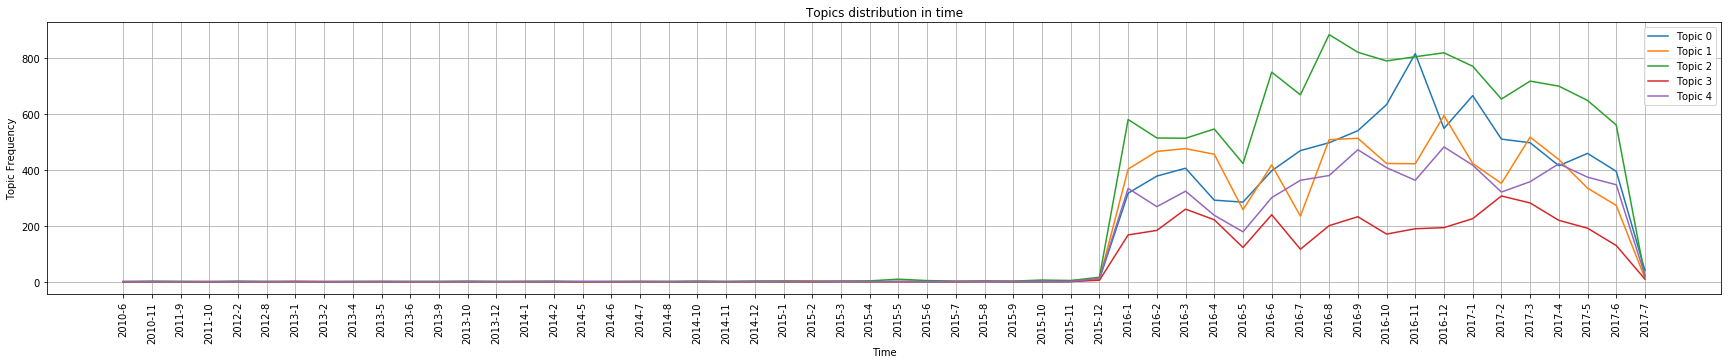

In [23]:
from matplotlib.pylab import datestr2num
plt.figure(figsize=(30,5))
plt.title("Topics distribution in time")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Topic Frequency")
plt.plot(date_list,topic0_list,'-',label="Topic 0")
plt.plot(date_list,topic1_list,'-',label="Topic 1")
plt.plot(date_list,topic2_list,'-',label="Topic 2")
plt.plot(date_list,topic3_list,'-',label="Topic 3")
plt.plot(date_list,topic4_list,'-',label="Topic 4")
plt.legend()
plt.grid()

# Overall daily sentiment for each topic.

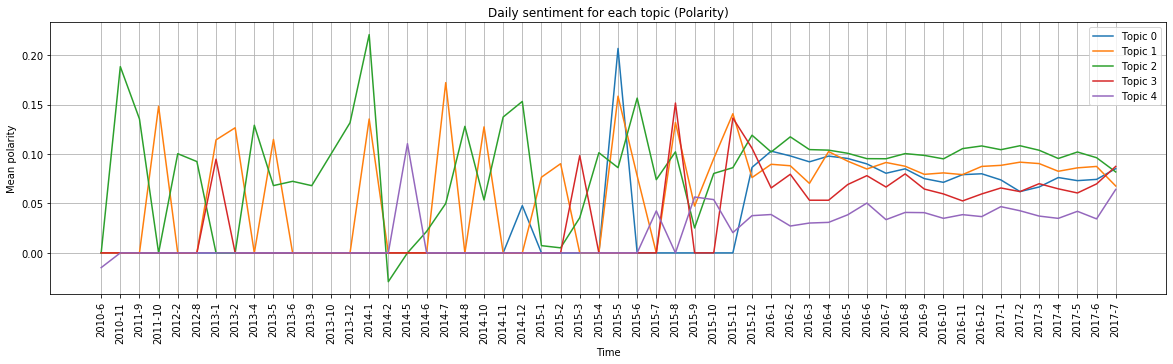

In [24]:
plt.figure(figsize=(20,5))
plt.title("Daily sentiment for each topic (Polarity)")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Mean polarity")
plt.plot(date_list,mean_pol[0],'-',label="Topic 0")
plt.plot(date_list,mean_pol[1],'-',label="Topic 1")
plt.plot(date_list,mean_pol[2],'-',label="Topic 2")
plt.plot(date_list,mean_pol[3],'-',label="Topic 3")
plt.plot(date_list,mean_pol[4],'-',label="Topic 4")
plt.legend()
plt.grid()

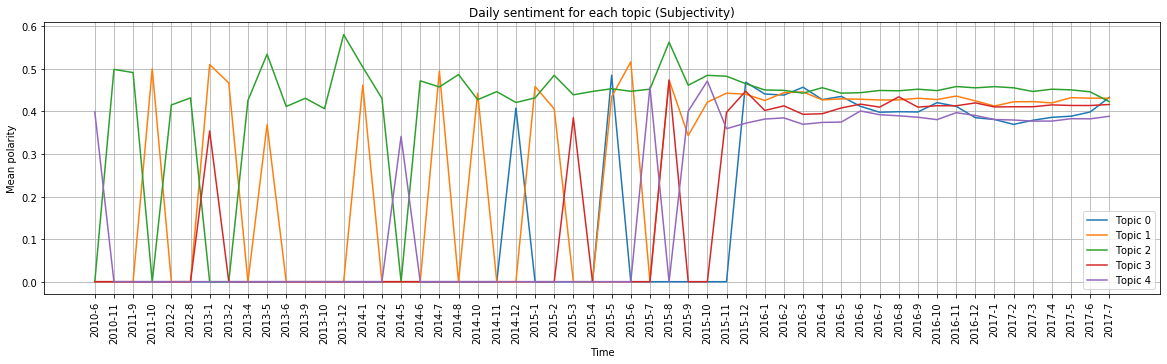

In [25]:
plt.figure(figsize=(20,5))
plt.title("Daily sentiment for each topic (Subjectivity)")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Mean polarity")
plt.plot(date_list,sub_pol[0],'-',label="Topic 0")
plt.plot(date_list,sub_pol[1],'-',label="Topic 1")
plt.plot(date_list,sub_pol[2],'-',label="Topic 2")
plt.plot(date_list,sub_pol[3],'-',label="Topic 3")
plt.plot(date_list,sub_pol[4],'-',label="Topic 4")
plt.legend()
plt.grid()